# Trabalho Prático 1: Compressão de Imagens

##  Integrantes do Grupo: Nome e Matrícula
    1. 
    


# Sobre o trabalho:

## Métodos de compressão:

O objetivo deste trabalho era a implementação de um algoritmo de compressão e descompressão de um arquivo de imagem. Sendo assim, o algoritmo aqui implementado realiza a compressão do arquivo em duas etapas: A primeira utiliza o domínio da frequência, pela aplicação da DCT, e em seguida a Codificação por comprimento de corrida.

### Transformação para o domínio da frequência:

Aqui foi aplicada a transformada discreta do cosseno (DCT) em blocos. Por padrão, definimos os blocos de dimensão 8x8, entretanto, criamos um novo bloco, de tamanho padrão 5x5, em que os coeficientes mais significativos da DCT foram aproveitados. Assim, conseguimos aproveitar uma taxa de compressão significativa. O efeito provocado na imagem é o borramento sutil, pois eliminamos algumas bordas mais finas, pois perdemos parte da informação contida na imagem ao desconsiderar alguns coeficientes da DCT.
Além disso, aplicamos um padding nas imagens se necessário, assim o método é eficiente independentemente da resolução das imagens.

### Codificação por comprimento de onda:

Essa etapa ocorre após a aplicação da DCT. Criamos um array que contém todos os coeficientes obtidos pela transformada. Nesse array aplicamos a codificação, entretanto, *apenas para as sequências de zeros*. Em seguida, salvamos em um arquivo _.out_ junto com um cabeçalho contendo informações importantes para a decodificação.

## Métodos de descompressão:

### Decodificar o arquivo salvo:

O arquivo salvo é lido, separamos as informações do cabeçalho e decodificamos o comprimento de corrida para obter os coeficientes da DCT reduzida.

### Aplicar a transformada inversa:

Reconstruímos a matriz da DCT original, ou seja, do tamanho real da imagem a partir da reduzida. Em seguida, aplicamos a transformada inversa para obter a reconstrução da imagem original.



## Funções Auxiliares

In [ ]:
%matplotlib inline
import cv2
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import fftpack
import matplotlib.image as mpimg

In [ ]:
%matplotlib inline
import cv2
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import fftpack
import matplotlib.image as mpimg

def get_2D_dct(input_img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(input_img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

# Calcula o rmse
def calc_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calcula o psnr
def calc_psnr(predictions, targets):
    rmsev = calc_rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

# Retorna o tamanho de um arquivo em bytes
def sizeA(file_path):
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return file_info.st_size

# Printa a imagem 'input_img' em tons de cinza com range 'rang'
def img_gray(input_img, window_name, rang=(0,255)):
    #plt.subplot(121)
    plt.imshow(input_img, cmap = 'gray', clim=rang)
    plt.title(window_name+" - "+str(input_img.shape)), plt.xticks([]), plt.yticks([])
    plt.show()

# Salvar imagem em PNG
def saveImg(input_img, name):
    mpimg.imsave(name+".png", input_img, 0, 255, cmap='gray')


# Determina o formato da matriz da DCT
def findDctShape(size, step):
  shape = (size[0]+(step-(size[0]%step))%step,
             size[1]+(step-(size[1]%step))%step)
  return shape

def findReducedShape(dctShape, step, difference):
  shape = (dctShape[0]-(difference*dctShape[0]//step),
              dctShape[1]-(difference*dctShape[1]//step))
  return shape

# Quantização
def findQuantizer(rDCT):
  Q = np.max(np.absolute(rDCT))/127
  return Q

def quantize(rDCT, Q):
  rDCT = rDCT/Q
  return rDCT

# Compression Rate
def compressionRate(A, B):
  cr = ((100-(A.size/B.size)*100))
  return cr

# Codificação do comprimento de onda
def encoding(arrayDCT, codedArray):
  i=0
  while i < len(arrayDCT):
      if (arrayDCT[i]!=0):
          codedArray.append(arrayDCT[i])
          i+=1
      else:
          count=1
          while(i+count<len(arrayDCT) and count<127 and arrayDCT[i+count]==0):
              count+=1
          codedArray.append(0)
          codedArray.append(count)
          i+=count
  return codedArray

# Header
def setupHeader(size, Q, step, reducedStep):
  h = size[0]
  hq = h//255
  hr = h%255

  w = size[1]
  wq = w//255
  wr = w%255

  # Colocando o header
  header = [hq, hr, wq, wr, Q, step, reducedStep]
  return header

# Decoder
def decode(coded, decoded):
  i=0
  while i < len(coded):
      if coded[i] != 0:
          decoded.append(coded[i])
          if (i == len(coded)-2):
              decoded.append(coded[i+1])
      else:
          for j in range(coded[i+1]):
              decoded.append(0)
          i+=1
      i+=1
  decoded = np.array(decoded,dtype = np.int8)
  return decoded

# Expansão da rDCT para a DCT
def expansion(rDCT, rdctShape, reducedStep, step):
  difference = step - reducedStep
  for y in range(0,rdctShape[0],reducedStep):
    for x in range(0,rdctShape[1],reducedStep):
        block = np.zeros((step,step),dtype=np.float)
        block[:reducedStep, :reducedStep] = rDCT[y:y+reducedStep, x:x+reducedStep]
        DCT[y+(difference*y//reducedStep):y+(difference*y//reducedStep)+step,
            x+(difference*x//reducedStep):x+(difference*x//reducedStep)+step] = block
  return DCT


# Compressão

## Abrindo a Imagem

_Atribua à variável "imgName" o nome da imagem a ser comprimida._

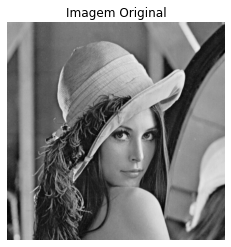

In [ ]:
# Nome do arquivo da imagem a ser comprimida
imgName = 'lena512.pgm'

# Carrega e armazena a imagem em um np.ndarray com elemento do tipo uint8
imgInput = cv2.imread(imgName, 0)

# Plota a imagem que foi carregada
plt.title('Imagem Original')
plt.imshow(imgInput, cmap='gray')
plt.axis('off')
plt.show()


## Aplicando a Transfomada

A DCT é aplicada em blocos de 8x8, tradicionalmente. Dentro de cada bloco aproveitamos subblocos com os coeficientes mais significativos, esses blocos são, por padrão, de tamanho 5x5. Aplicamos também uma normalização para o intervalo [-127, 127].

In [ ]:
# Formato da imagem
size = imgInput.shape

# Tamanho do bloco da DCT e do bloco reduzido
step = 8
reducedStep = 5
difference = step - reducedStep

# Tamanho da matriz da DCT (com padding se necessário)
dctShape = findDctShape(size,step)

# Tamanho da matriz DCT reduzida
rdctShape = findReducedShape(dctShape, step, difference)

# Geramos as matrizes para a DCT e a DCT reduzida
DCT = np.zeros(dctShape, dtype=np.float)
rDCT = np.zeros(rdctShape, dtype=np.float)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


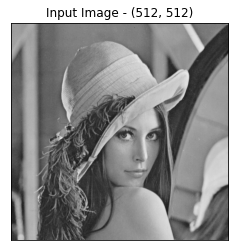

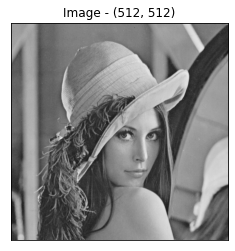

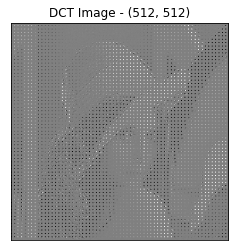

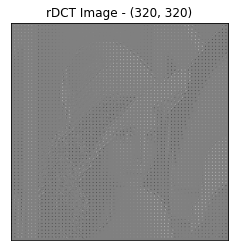

Taxa de compressão da DCT reduzida: 60.938%


In [ ]:
# Imagem normalizada
img = np.zeros(dctShape, dtype=float)
img[:size[0],:size[1]] = (imgInput.astype(float))-128

for y in range(0,size[0],step):
  y_reduced = y*reducedStep//step
  for x in range(0,size[1],step):
    x_reduced = x*reducedStep//step
    dct = get_2D_dct(img[y:y+step, x:x+step])
    DCT[y:y+step, x:x+step] = dct
    # DCT reduzida
    rDCT[y_reduced:y_reduced+reducedStep,
         x_reduced:x_reduced+reducedStep] = dct[:reducedStep,:reducedStep]

Q = findQuantizer(rDCT)
rDCT = quantize(rDCT, Q)

# Truncamos os coeficientes
rDCT = rDCT.astype(np.int8)

img_gray(imgInput,"Input Image")
img_gray(img,"Image", (-128,127))
img_gray(DCT,"DCT Image", (-128,127))
img_gray(rDCT,"rDCT Image", (-128,127))

print("Taxa de compressão da DCT reduzida: {:.3f}%".format(compressionRate(rDCT, imgInput)))


# Codificação por comprimento de onda:

Implementamos o algoritmo de comprimento de corrida apenas para os zeros. Nesse caso, como essas são as maiores sequências, não há um impacto muito significativo em termos de compressão, mas o impacto é alto em termos computacionais caso fossemos aplicar para todas as sequências. Por esses motivos, optamos pela simplicidade. Ainda assim, aplicar o algoritmo nos zeros tende a reduzir consideravelmente o número de bytes necessários para armazenas a transformada reduzida.

## Header:

Para reconstruir a imagem reduzida na decodificação, precisamos dos seguintes valores:
- **Dimensão original da imagem:** size
- **Valor de quantização:** Q
- **Parâmetros da DCT:** step e stepReduced


In [ ]:
# DCT -> array unidimensional
arrayDCT = np.asarray(rDCT).reshape(-1)

# Array Codificado
codedArray = []

# Loop para gerar o array com os comprimentos de corrida dos zeros
codedArray = encoding(arrayDCT, codedArray)

header = setupHeader(size, Q, step, reducedStep)
header.extend(codedArray)

codedArray = np.array(header, dtype=np.int8)

# Taxa de compressão
print("Taxa de compressão da DCT reduzida: {:.3f}%".format(100-len(codedArray)/len(arrayDCT)*100))

print("Tamanho do array com header: {} bytes".format(len(codedArray)))

Taxa de compressão da DCT reduzida: 37.459%
Tamanho do array com header: 64042 bytes



# Salvando arquivo e calculando a taxa de compressão total

Ao final da codificação, temos um array unidimensional contendo a transformada reduzida codificada.


In [ ]:
# Salvando a imagem original como .out
file = open("original_image.out", "w")
imgInput.tofile(file,sep="")
file.close()

# Salvando a imagem comprimida como .out
file = open("compressed.out", "w")
codedArray.tofile(file,sep="")
file.close()

# Taxa de compressão total
compression_rate = 1-(sizeA("compressed.out")/sizeA("original_image.out"))
print("Taxa de compressão total: {:.3f}%".format(compression_rate * 100))

Taxa de compressão total: 75.570%


# Descompressão

## Abrindo a imagem comprimida e extraindo o Header

Abrimos a imagem comprimida e extraímos as informações armazenadas no header.

In [ ]:
# Nome do arquivo contendo a imagem comprimida
codedName = "compressed.out"

# Salvando esse arquivo em um array
file = open(codedName,"r")
coded = np.fromfile(file,dtype = np.int8,sep="")
file.close()

# Separando o cabeçalho da imagem
header = coded[:7]
coded = coded[7:]

# Dimensão da imagem original armazenado no header
size = (np.uint8(header[0])*255 + np.uint8(header[1]),
              np.uint8(header[2])*255 + np.uint8(header[3]))

# Valor de quantização
Q = header[4]

# Parâmetros da DCT
step    = header[5]
stepReduced = header[6]
difference = step - stepReduced

# Informações do header
print("---Dados recuperados do Header---\n")
print("Dimensão da imagem original:\n orig_shape = {}\n".format(size))
print("Valor de quantização:\n Q = {}\n".format(Q))
print("Parâmetros da DCT:\n step = {0}\n sv_step = {1}".format(step, stepReduced))

---Dados recuperados do Header---

Dimensão da imagem original:
 orig_shape = (512, 512)

Valor de quantização:
 Q = 6

Parâmetros da DCT:
 step = 8
 sv_step = 5


# Decoding

Realizamos o processo de decodificação, obtendo o array da imagem transformada reduzida.

In [ ]:
# Array decodificado
decoded = []

# Decodifica o arquivo de bytes gerado pela compressão
decoded = decode(coded, decoded)

print("Array decodificado: {} bytes".format(len(decoded)))

Array decodificado: 102400 bytes


# Transformada Inversa

Com o array unidimensional decodificado, podemos redimensioná-lo para obter a matriz da DCT reduzida. Com ela, restauramos a DCT original e aplicamos a transformada inversa.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias f

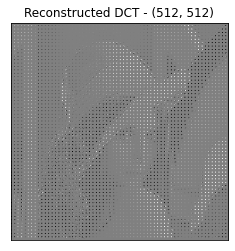

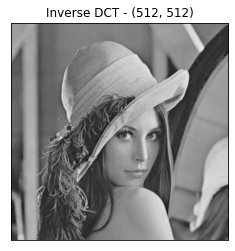

In [ ]:
dctShape = findDctShape(size, step)
rdctShape = findReducedShape(dctShape, step, difference)

# Reshaping o decoded array para o tamanho da matriz DCT reduzida
rDCT = decoded.reshape(rdctShape)

# Matriz da DCT completa
DCT = np.zeros(dctShape, dtype=np.float)

# Expandindoa rDCT para a dimensão original
DCT = expansion(rDCT, rdctShape, reducedStep, step)

# Reverte a quantização
DCT = Q * DCT

# Inverse DCT
iDCT = np.zeros(dctShape, dtype=np.float)

# Transformada Inversa
for y in range(0,dctShape[0],step):
    for x in range(0,dctShape[1],step):
        block = get_2d_idct(DCT[y:y+step, x:x+step])
        iDCT[y:y+step, x:x+step] = block

# Mostra as imagens obtidas
img_gray(DCT,          "Reconstructed DCT", (-128,127))
img_gray(iDCT,  "Inverse DCT", (-128,127))



# Análise

Abaixo mostramos o PSNR obtido com a reconstrução. De maneira opcional, salvamos as imagens, original e reconstruida, em '.png' a fim de realizar uma comparação visual dos resultados obtidos.

PSNR = 36.883
Taxa de compressão = 75.570%


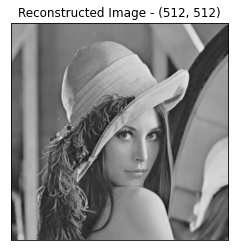

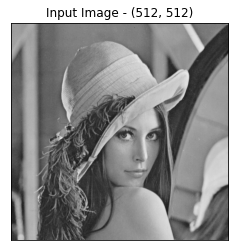

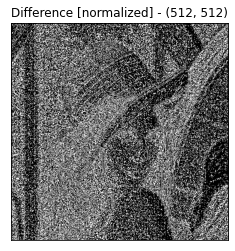

In [ ]:
# Imagem reconstruida
reconstructedImg = np.uint8(iDCT[:size[0], :size[1]]+128)

# Calcular PSNR
psnr = calc_psnr(np.uint8(imgInput), reconstructedImg)
# Mostrar valores obtidos nas métricas
print("PSNR = {:.3f}".format(psnr))
print("Taxa de compressão = {:.3f}%".format(compression_rate*100))

# Mostrar imagem de entrada / imagem reconstruida / diferença entre as imagens
img_gray(reconstructedImg, "Reconstructed Image")
img_gray(imgInput, "Input Image")
imgDifference = abs(imgInput-reconstructedImg)
img_gray(imgDifference, "Difference [normalized]", (np.min(imgDifference),np.max(imgDifference)))

saveImg(imgInput, "{0}".format("lena512.pgm".split('.')[0]))
saveImg(reconstructedImg, "{0}-{1}_{2}_[{3:.2f}]_[{4:.2f}]".format("lena512.pgm".split('.')[0], step, stepReduced, compression_rate*100, psnr))
